#***Deep Learning Homework 4: Recurrent Neural Networks & Transformer***
### MSc Computer Science, Data Science, Cybersecurity @UNIPD
### 2nd semester - 6 ECTS
### Prof. Alessandro Sperduti, Prof. Nicolò Navarin and Prof. Luca Pasa
---
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. We will use the IMDB dataset---it contains the text of some reviews and the sentiment given by their authors (either positive or negative). The input to the RNN is the sequence of words that compose a review, so the learning task consists in predicting the overall sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will solve the same classification problem with a Transformer, in order to have a closer look at its internal functioning.

---
##**Important Instructions for Submissions:**

Generally, in the homeworks, you will be either required to complete a part of Python code or to answer questions in text cells. Code and text cells where you are expected to write your answers have been marked by `%STARTCODE` and `%ENDCODE` or `%STARTEXT` and `%ENDTEXT` tags, respectively. Note that you should never change, move or remove these two tags, otherwise your answers will be __not__ valid. As you will see in this notebook, each cell that includes a `[TO COMPLETE]` part has been put between these placeholders.

#Requirements

In [1]:
!pip3 install datasets skorch torchinfo torchdata torchtext torchvision matplotlib portalocker>=2.0.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.


# Imports

In [2]:
import torch
torch.utils.data.datapipes.utils.common.DILL_AVAILABLE = torch.utils._import_utils.dill_available()
from torch import nn
from torch.nn import Embedding, RNN, LSTM, GRU, Linear, Transformer
import torch.nn.functional as F
from torchinfo import summary
from torchtext.datasets import IMDB
from torch.utils.data import DataLoader, Dataset, random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchvision.transforms import Lambda
from timeit import default_timer as timer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)
rng = np.random.default_rng(seed=4242)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torchtext/datasets/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext i

#Data Loading and Preprocessing

###Load dataset:
In this HW, we use the same datset used in the HW2, the IMDB dataset. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). As usual, for speed and efficiency, we will use only a subset of the dataset. Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. We load the data from the PyTorch database and then split the data into train, validation and test set.

In [3]:
train, test = IMDB(root="dataset", split=('train', 'test')) # This is a Torch "datapipeline"
train.shuffle()
test.shuffle()
len_train, len_val, len_test = 25000, 12500, 12500 # Whole data
# Build validation set
valid, test = test.random_split(total_length=len_test*2, weights={"valid": 0.5, "test": 0.5}, seed=42)
# Get data from the pipeline
train_data = [x for x in train]
test_data = [x for x in test]
val_data = [x for x in valid]

In [4]:
len(train_data), len(val_data), len(test_data)

(25000, 12500, 12500)

In [5]:
idx = 10
label_samp, text_samp = train_data[idx]
print(f"text: {text_samp}")
print(f"label: {label_samp}")

text: It was great to see some of my favorite stars of 30 years ago including John Ritter, Ben Gazarra and Audrey Hepburn. They looked quite wonderful. But that was it. They were not given any characters or good lines to work with. I neither understood or cared what the characters were doing.<br /><br />Some of the smaller female roles were fine, Patty Henson and Colleen Camp were quite competent and confident in their small sidekick parts. They showed some talent and it is sad they didn't go on to star in more and better films. Sadly, I didn't think Dorothy Stratten got a chance to act in this her only important film role.<br /><br />The film appears to have some fans, and I was very open-minded when I started watching it. I am a big Peter Bogdanovich fan and I enjoyed his last movie, "Cat's Meow" and all his early ones from "Targets" to "Nickleodeon". So, it really surprised me that I was barely able to keep awake watching this one.<br /><br />It is ironic that this movie is about a 

Let's check the dataset statistics.

In [6]:
datasets = {'train':train_data, 'val':val_data, 'test':test_data}
for key in datasets:
  label_dist = {}
  dataset = datasets[key]
  for lb, txt in dataset:
    if lb not in label_dist:
      label_dist.setdefault(lb, 1)
    else:
      label_dist[lb] += 1
  print(f"{key}:")
  print(label_dist)


train:
{1: 12500, 2: 12500}
val:
{1: 6245, 2: 6255}
test:
{1: 6255, 2: 6245}


In [7]:
tokenizer = get_tokenizer('basic_english')

def create_tokens(dataset):
  for sample in dataset:
    yield tokenizer(sample[1])

vocab = build_vocab_from_iterator(create_tokens(train_data), specials=["<oov>", "<sos>"], max_tokens=10000)
vocab.set_default_index(vocab["<oov>"])
print(f"Our vocabulary is made of {len(vocab)} tokens-index pairs.")

Our vocabulary is made of 10000 tokens-index pairs.


In [8]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [9]:
print(vocab.get_itos())  # top 10000 freq words (including special chars)

['<oov>', '<sos>', 'the', '.', ',', 'and', 'a', 'of', 'to', "'", 'is', 'it', 'in', 'i', 'this', 'that', 's', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', ')', '(', 'you', 't', 'on', 'not', 'he', 'are', 'his', 'have', 'be', 'one', '!', 'all', 'at', 'they', 'by', 'an', 'who', 'from', 'so', 'like', 'there', 'her', 'or', 'just', 'about', 'if', 'has', 'out', 'what', '?', 'some', 'good', 'can', 'more', 'when', 'she', 'very', 'even', 'my', 'no', 'up', 'would', 'time', 'which', 'only', 'story', 'really', 'their', 'see', 'had', 'we', 'were', 'me', 'than', 'well', 'much', '-', 'get', 'been', 'people', 'will', 'also', 'other', 'bad', 'into', 'do', 'because', 'great', 'first', 'how', 'him', 'don', 'most', 'its', 'made', 'then', 'them', 'way', 'could', 'make', 'too', 'any', 'after', 'movies', 'think', 'characters', 'character', 'watch', 'films', 'two', 'many', 'seen', 'being', 'never', 'little', 'plot', 'acting', 'where', 'best', 'love', 'did', 'life', 'show', 'know', 'does', 'ever', 'here',

In [10]:
word_index = {k:v for (k, v) in enumerate(vocab.get_itos())}

In [11]:
def decode_review(word_ids):
    return " ".join([word_index.get(word_id, "<err>") for word_id in word_ids])

print(text_samp)
print("\n")
print(decode_review(text_pipeline(text_samp)))

It was great to see some of my favorite stars of 30 years ago including John Ritter, Ben Gazarra and Audrey Hepburn. They looked quite wonderful. But that was it. They were not given any characters or good lines to work with. I neither understood or cared what the characters were doing.<br /><br />Some of the smaller female roles were fine, Patty Henson and Colleen Camp were quite competent and confident in their small sidekick parts. They showed some talent and it is sad they didn't go on to star in more and better films. Sadly, I didn't think Dorothy Stratten got a chance to act in this her only important film role.<br /><br />The film appears to have some fans, and I was very open-minded when I started watching it. I am a big Peter Bogdanovich fan and I enjoyed his last movie, "Cat's Meow" and all his early ones from "Targets" to "Nickleodeon". So, it really surprised me that I was barely able to keep awake watching this one.<br /><br />It is ironic that this movie is about a detect

To keep the length of the all the input sequences same, we define the padding function. All the sentence less than the lenght of 500 will be padded with zeros and greater than 500 will be truncated. Notice that we will pad and truncate sequences right-wise, so that processing the sequences, the final hidden states of the recurrent networks will correspond to the final words of each sequence in the batch.



In [12]:
def sent_padding(sent_vec, maxlen):
  sent_vec = torch.tensor(sent_vec)
  maxlen -= len(sent_vec)
  return F.pad(sent_vec, (maxlen, 0))


print(sent_padding([1,2,3], maxlen=6))
print(sent_padding([1,2,3,4,5,6,7,8,9], maxlen=6))

tensor([0, 0, 0, 1, 2, 3])
tensor([4, 5, 6, 7, 8, 9])


In [13]:
seq_len = 500
sent_padding(text_pipeline(text_samp), maxlen=seq_len)

tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

In [14]:
class CustomDataset(Dataset):

  def __init__(self, dataset, seq_len=seq_len):
    super().__init__()
    self.dataset = dataset
    self.seq_len = seq_len

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    label, text = self.dataset[idx]
    label = label_pipeline(label)
    txt_rep = sent_padding(text_pipeline(text), maxlen=self.seq_len)
    label, txt_rep = torch.tensor(label, dtype=torch.float32), torch.tensor(txt_rep, dtype=torch.long)
    return label.to(device), txt_rep.to(device)

In [15]:
train_dataset = CustomDataset(train_data)
val_dataset = CustomDataset(val_data)
test_dataset = CustomDataset(test_data)

In [16]:
batch_size = 256
dataloader_training = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_validation = DataLoader(val_dataset, batch_size=batch_size)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size)

# Model Definition [TO COMPLETE]

#Model Definition

Let's define the model:
- The first layer is an Embedding layer, with input_dim=vocab_dim and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html), LSTM and GRU.
- The output layer is linear one that maps the model output to the target space and applies a sigmoid function (we are using a [Binary Cross-Entropy Loss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss) which, differently from Cross-Entropy Loss, expects probabilities as input)

### Model Comparison

In order to perform a fair comparison of the models RNN, LSTM and GRU make sure they use more or less the same number of parameters.

In the next cell, we define our simple RNN used for binary classification. The class has two main methods, the constructor (`init()`) and the `forward()` method.

In the constructor, the input parameters are used to define the layers and hyperparameters of the RNN. The layers that are defined include an embedding layer (`self.embedding`), a recurrent layer (`self.rnn`), and a linear layer (`self.linear`). The constructor also sets up various parameters such as the embedding input size, the embedding output size, the hidden size, the number of layers, the batch size, the RNN type, and whether or not the RNN is bidirectional.

The `forward()` method takes a batch of input data (`x`) and applies the layers defined in the constructor in a specific sequence. First, the input is passed through the embedding layer to create embeddings of the input tokens. These embeddings are then permuted to be of the correct shape for the RNN layer, which expects inputs of the form (`seq_len, batch_size, H_in`). The RNN layer is then applied to these embeddings, producing both the RNN output (`rnn_out`) and the last hidden state (`self.last_hidden`). Finally, the output of the RNN is passed through a linear layer and flattened to produce the final output of the network, which is a sigmoid activation function applied to a tensor of shape (`batch_size`). This output is then returned.

**[TO COMPLETE]** Implement the forward method.

`%STARTCODE%`

In [17]:
class My_RNN(nn.Module):
  def __init__(self, vocab_length, emb_dim, hidden_size, num_layers, rnn_dropout,
               batch_size, RNN_type, bidirectional, device=device):
    super().__init__()
    self.emb_in_dim = vocab_length  # 10000
    self.emb_out_dim = emb_dim  # 10
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.batch_size = batch_size
    self.RNN_type = RNN_type
    self.target_size = 1  # binary classification
    self.device = device
    self.D = 2 if self.bidirectional else 1  # enable/disable bidirectional

    valid_types = {'Simple RNN':RNN, 'LSTM':LSTM, 'GRU':GRU}
    assert self.RNN_type in valid_types.keys(), f'You must choose one of {valid_types.keys()} types'

    self.embedding = Embedding(self.emb_in_dim, self.emb_out_dim)

    chosen_rnn = valid_types[self.RNN_type]
    self.rnn = chosen_rnn(input_size=self.emb_out_dim, hidden_size=self.hidden_size,
                          num_layers=self.num_layers, dropout=rnn_dropout, bidirectional = self.bidirectional)

    self.linear = Linear(self.D*self.hidden_size, self.target_size)

  def forward(self, x):
    # x: (batch_size, 500)
    # [TO COMPLETE]
    self.embeds = self.embedding(x)
    # Embeds have shape (batch_size, 500, 10)
    # But rnn receives inputs of: (500, batch_size, 10) (seq_len, batch_size, H_in)
    # [TO COMPLETE]
    self.embeds = self.embeds.permute(1, 0, 2)
    rnn_out, self.last_hidden = self.rnn(self.embeds) # [TO COMPLETE]
    # rnn_out: (500, 256, 2*5:10) -> (seq_len, batch_size, D*hidden_size)
    # h_n: (1, 256, hidden_size) -> (D*num_layers, batch_size, hidden_size)
    output = self.linear(rnn_out[-1, :, :])
    # hint: pay attention to WHICH output dimension corresponds to the elements of the sequence
    #output: (256, 1) -> (batch_size, target_size)
    output = output.flatten()
    #output: (256) -> (batch_size)
    return F.sigmoid(output)

`%ENDCODE%`


The code below allows us to do a verifcation of the model in term of any implementation error. The script demonstrates the process of initializing a recurrent neural network model, loading data, performing inference, and inspecting the output using a simple example.







In [18]:
'''
CHECK I
'''
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 5
num_layers = 2
RNN_type = 'LSTM' #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = True
#BiDirectional GRU with 2 layers of hidden size of 5

model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, rnn_dropout=0, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

label, text = next(iter(dataloader_training))
x = model.forward(text)
print(x.shape)
print(x[52]) #sigmoid output

torch.Size([256])
tensor(0.5273, device='cuda:0', grad_fn=<SelectBackward0>)


Here, we use the My_RNN class to check the model summary for different models.

In [19]:
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 32
num_layers = 1
RNN_type = 'Simple RNN' #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = False
lr = 1e-3

model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, rnn_dropout=0, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

summary(model)
#if you see there is a differnce of 1408-1376=32 with the keras version
#that is because of the fact that keras does not consider bias terms for RNNs.

Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         100,000
├─RNN: 1-2                               1,408
├─Linear: 1-3                            33
Total params: 101,441
Trainable params: 101,441
Non-trainable params: 0

In [20]:
criterion = torch.nn.BCELoss()  # does not apply sigmoid
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [21]:
'''
Sanity Check II: Overfitting on one batch
'''
E = 500
label, text = next(iter(dataloader_training))
for itr in range(E):
    model.train()
    optimizer.zero_grad()
    logits = model(text)
    loss = criterion(logits, label)
    if itr % 100 == 0 or itr == E-1:
      print(f"epoch: {itr} -> Loss: {loss}")
    loss.backward()
    optimizer.step()

epoch: 0 -> Loss: 0.7043056488037109
epoch: 100 -> Loss: 0.16848118603229523
epoch: 200 -> Loss: 0.006360582076013088
epoch: 300 -> Loss: 0.1609906107187271
epoch: 400 -> Loss: 0.13433849811553955
epoch: 499 -> Loss: 0.03720540553331375


# Simple RNN

We define a Simple RNN model and evaluate its performance. We define the training and evaluation loop. The function takes the model, optimizer, dataloader_train, dataloader_val and epochs as input parameters. The function returns training loss, validation loss, training accuracy and validation accuracy to monitor the model performance.

In [22]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(epochs):
    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_train):
      optimizer.zero_grad()
      logits = model(text)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      labels_form_logits = lambda x: 0. if x < 0.5 else 1.
      logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
      total_acc_train += (logits == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)

    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (label, text) in enumerate(dataloader_val):
            logits = model(text)
            loss = criterion(logits, label)
            total_loss_val += loss
            logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
            total_acc_val += (logits == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val)
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

In [23]:
def plot_learning_acc_and_loss(loss_tr, acc_tr, loss_val, acc_val):

    plt.figure(figsize=(8, 10))

    plt.subplot(2, 1, 1)
    plt.grid()
    plt.plot(range(EPOCHS), acc_tr, label='acc_training')
    plt.plot(range(EPOCHS), acc_val, label='acc_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.grid()
    plt.plot(range(EPOCHS), loss_tr, label='loss_training')
    plt.plot(range(EPOCHS), loss_val, label='loss_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

## Train an RNN [TO COMPLETE]

Your task is then to train the Deep Learning model:
* keep the number of epochs fixed (same for all models)
* do not overfit the training set: we care about generalization, so performance on the val set should be reasonably close (withing a few % pts) to that of the training set. You can use regularization techniques such as dropout and weight decay
* try to get a good performance (at least 70% validation accuracy!)
* keep in the cells below only the outputs of the best model configuration you find.

`%STARTCODE%`

In [39]:
emb_dim =  128 # [TO COMPLETE]
hidden_size = 128  # [TO COMPLETE]
num_layers =  2 # [TO COMPLETE]
rnn_dropout =  0.5 # [TO COMPLETE]
lr =  1e-4 # [TO COMPLETE]

vocab_length = len(vocab)
EPOCHS = 75

model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, rnn_dropout=rnn_dropout, RNN_type='Simple RNN',
               bidirectional=False).to(device)

criterion = torch.nn.BCELoss() #does not apply sigmoid
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-2) #1e-2

In [40]:
summary(model)

Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         1,280,000
├─RNN: 1-2                               66,048
├─Linear: 1-3                            129
Total params: 1,346,177
Trainable params: 1,346,177
Non-trainable params: 0

In [41]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 52.56%, Loss: 0.69168627 ---------------- Val_Acc: 55.16%, Val_Loss: 0.68592644
epoch: 2 -> Accuracy: 54.92%, Loss: 0.68476796 ---------------- Val_Acc: 55.94%, Val_Loss: 0.68095511
epoch: 3 -> Accuracy: 57.40%, Loss: 0.67701876 ---------------- Val_Acc: 57.74%, Val_Loss: 0.67225504
epoch: 4 -> Accuracy: 58.76%, Loss: 0.66682512 ---------------- Val_Acc: 60.12%, Val_Loss: 0.65828323
epoch: 5 -> Accuracy: 62.09%, Loss: 0.64718980 ---------------- Val_Acc: 63.22%, Val_Loss: 0.64544195
epoch: 6 -> Accuracy: 66.57%, Loss: 0.61603028 ---------------- Val_Acc: 67.44%, Val_Loss: 0.60268414
epoch: 7 -> Accuracy: 68.12%, Loss: 0.60261971 ---------------- Val_Acc: 66.25%, Val_Loss: 0.61441940
epoch: 8 -> Accuracy: 68.56%, Loss: 0.59622103 ---------------- Val_Acc: 68.65%, Val_Loss: 0.59334993
epoch: 9 -> Accuracy: 69.51%, Loss: 0.58617663 ---------------- Val_Acc: 68.95%, Val_Loss: 0.59473085
epoch: 10 -> Accuracy: 70.04%, Loss: 0.58158529 ---------------- Val_Acc: 70.00%, 

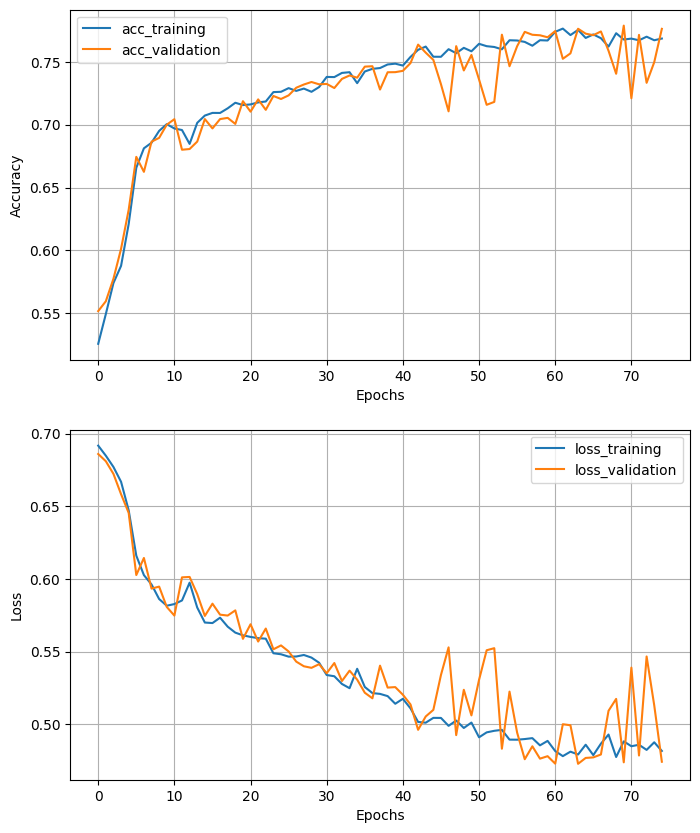

In [42]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [43]:
def test(model, dataloader_test=dataloader_test):
  model.eval()
  total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0
  for idx, (label, text) in enumerate(dataloader_test):
      pre_label = model(text)
      loss += criterion(pre_label, label)
      labels_form_pre_label = lambda x: 0. if x < 0.5 else 1.
      pre_label = torch.tensor(list(map(labels_form_pre_label, pre_label))).to(model.device)
      total_acc_test += (pre_label == label).sum().item()
      total_count_test += label.size(0)
      n_batches_test += 1
  accuracy_test = total_acc_test/total_count_test
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
  print(f"Test Accuracy: {100*accuracy_test:.4f}%")


In [44]:
test(model)

Test Loss: 0.48573524 ---------- Test Accuracy: 76.4640%


`%ENDCODE%`

## Improve over the baseline [TO COMPLETE]
* Try to improve over the result you obtained with the RNN using a different architecture. You can experiment with GRU, LSTM and BiLSTM
* Do not change the number of epochs
* Try to keep the number of parameters the same as that of the RNN, so that you can make a fair comparison between different architectures
* Do not overfit the training set: as before, the performance of the validation set should be within a few percentage points that on the training set. You can use regularization techniques such as dropout and weight decay
* You should be able to reach at least 80% accuracy on the validation set
* Report in a table a comparison of a few models and hyperparameters configurations that you tried. Report: model name (LSTM, GRU, etc), hyperparameters values (emb_dim, hidden_size, num_layers, lr, dropout, etc), number of parameters, training accuracy, validation accuracy, training time.
* Keep in the cells below only the outputs of the best training run
* at the end, discuss and report your results.

`%STARTCODE`

In [30]:
vocab_length = len(vocab)
emb_dim = 128#[TO COMPLETE]
hidden_size = 128#[TO COMPLETE]
num_layers = 2#[TO COMPLETE]
RNN_type = 'GRU'#[TO COMPLETE] # possible choices -> ['Simple RNN', 'LSTM', 'GRU']
rnn_dropout = 0.5#[TO COMPLETE]
lr = 1e-4#[TO COMPLETE]
bidirectional = False

EPOCHS = 75

model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, rnn_dropout=rnn_dropout, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

criterion = torch.nn.BCELoss()#does not apply sigmoid
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-2) #Added weight decay to avoid overfitting
summary(model)

Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         1,280,000
├─GRU: 1-2                               198,144
├─Linear: 1-3                            129
Total params: 1,478,273
Trainable params: 1,478,273
Non-trainable params: 0

In [31]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 52.78%, Loss: 0.69082564 ---------------- Val_Acc: 55.02%, Val_Loss: 0.68836445
epoch: 2 -> Accuracy: 55.04%, Loss: 0.68749470 ---------------- Val_Acc: 56.78%, Val_Loss: 0.68541986
epoch: 3 -> Accuracy: 56.41%, Loss: 0.68442816 ---------------- Val_Acc: 57.40%, Val_Loss: 0.68226832
epoch: 4 -> Accuracy: 57.48%, Loss: 0.68036383 ---------------- Val_Acc: 58.06%, Val_Loss: 0.67801219
epoch: 5 -> Accuracy: 58.03%, Loss: 0.67583209 ---------------- Val_Acc: 58.42%, Val_Loss: 0.67315835
epoch: 6 -> Accuracy: 59.32%, Loss: 0.66935474 ---------------- Val_Acc: 59.19%, Val_Loss: 0.66765338
epoch: 7 -> Accuracy: 59.79%, Loss: 0.66453803 ---------------- Val_Acc: 59.85%, Val_Loss: 0.66315675
epoch: 8 -> Accuracy: 60.34%, Loss: 0.65972859 ---------------- Val_Acc: 60.56%, Val_Loss: 0.65943414
epoch: 9 -> Accuracy: 60.79%, Loss: 0.65625954 ---------------- Val_Acc: 61.13%, Val_Loss: 0.65619087
epoch: 10 -> Accuracy: 61.40%, Loss: 0.65341675 ---------------- Val_Acc: 61.39%, 

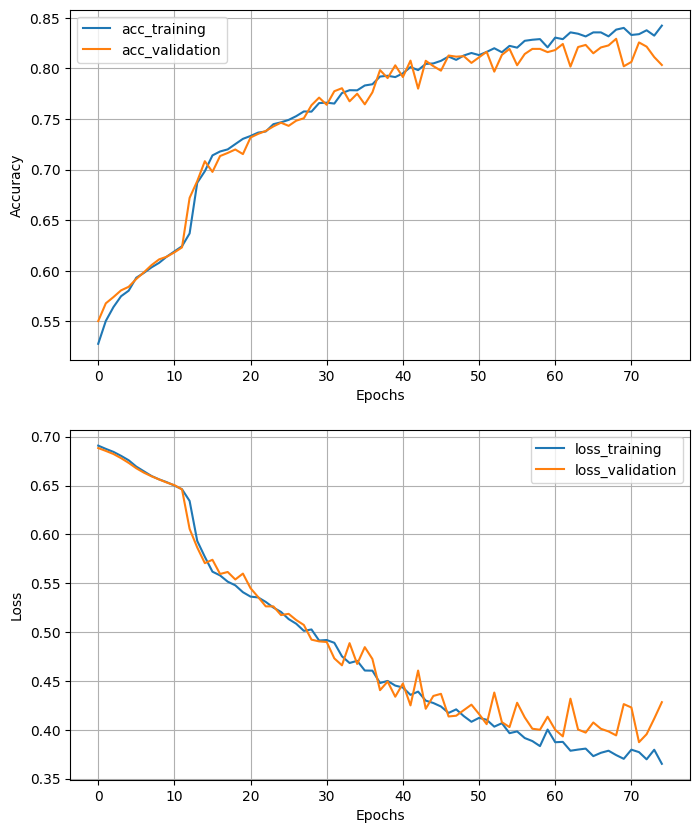

In [32]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [33]:
test(model)

Test Loss: 0.42661950 ---------- Test Accuracy: 80.3360%


**[TO COMPLETE]** Discuss and report your results:

|Model name|Hyperparameters cfg|# parameters|Accuracy (Tr)|Accuracy (Val)|Training time|Iterations|
|-|-|-|-|-|-|-|
|Simple RNN|128/265/4/0.5/0.001|1,773,825|75.16|75.94|..|30|
|Simple RNN|128/128/2/0.2/0.0001|1,346,177|91.50%|83.34%|1478.93|75|
|LSTM|128/128/4/0.2/0.0001|1,773,825|98.56%|86.51%|2834.23|75|
|GRU|128/128/6/0.2/0.0001|1,478,273|99.36%|86.82%|1754.03|75|
|GRU|128/128/6/0.2/0.0001|1,874,561|99.36%|86.82%|1754.03|75|
|GRU|128/128/2/0.1/0.0001|1,478,273|99.28%|87.41%|1749.81|75|
|GRU|128/128/2/0.05/0.0001|1,478,273|99.36%|86.92%|1667.07|75|
|GRU|256/128/2/0.05/0.0001|1,478,273|97.15%|87.62%|-|35|
|GRU|128/128/2/0.05/0.0001|1,478,273|99.65%|89.16%|594.62|25|
|LSTM|128/128/2/0.2/0.001|1,478,273|97.20%|87.22%|614.65|25|
|GRU|	64/64/2/0.4/0.0001|1,478,273|86.38%|82.50%|461.30|25|
|LSTM|128/128/2/0.5/0.0001|1,478,273|98.56%|86.46%|1829.740|75|
|GRU|	64/64/2/0.4/0.0001|1,478,273|84.24%|80.34%|1563.25|75|

For evaluating these architectures for binary text classification, I started first as a baseline to then apply all the models and start with the best performing ones. Each run was about half an hour in lenght, with a colab cooldown of 90 minutes per account, so testing was challenging.

**Initial Observations:**
- The **Simple RNN** models, had less partameters and ther was a gap between training and validation accuracy, indicating potential overfitting.
- The **LSTM** model was promising due to the ability of learning long patterns and performed better than the Simple RNN in terms of validation accuracy but took longer to train.
- The **GRU** models consistently showed high training accuracy, with the best models also achieving high validation accuracy.

After that I then moved to the Hyperparameters and changing then to achieve the best accuracy.

**Hyperparameter Tuning:**
- I experimented with different **embedding dimensions** (emb_dim), **hidden sizes**, **number of layers**, **dropout rates**, and **learning rates** (lr).
- A higher number of layers increased the model's capacity but didn't necessarily lead to better validation performance. So I scrapped the Idea of adding more.
- Adjusting the **dropout rate** was really important, maybe the most importand hyperparameter, helping to close the gap between training and validation accuracy.
- After the first failed submission I noticed that the model was, in fact, overfitting, and as such I reavaluated the model using **Weight decay** to make it fit better

**Model Selection:**
- The **GRU** models stood out, particularly those with a **dropout rate of 0.1** and **0.05**. They achieved over **99%** training accuracy and approximately **87%** validation accuracy. Testing with more varied and overall better data  could help with the overfitting I noticed, having training accuracy so high means that there is room for eventual improvement.
- The best GRU model, with a **dropout rate of 0.05**, achieved a **validation accuracy of 87.62%**. This model balanced complexity and regularization well, as evidenced by its high training accuracy and the closest validation accuracy to the training set.
- Despite the **High validation accuracy** the model was still overfitting a lot. By the instructions on given by the professor I noticed I could adjust the **weight decay** to avoid overfitting. After doing that the model had of course lower score (but in line with the question by the professor) but the overfittin was kept in check

**Conclusion:**
- The **GRU** model with **128/128/2/0.5/1e-4** hyperparameters configuration is the best among the tested models. It has a good balance of capacity and regularization, leading to high accuracy without overfitting.
- Also promising is the **GRU** model with more nodes and higher complexity, wich in the first iteration performed better, and cut off before it could overfit more. It is a result with less epochs but still worth to consider.
- The **LSTM** model is a close second, but the longer training time and slightly lower validation accuracy make the GRU model more appealing.
- Using a higher Weigth decay was way to aggressive, leading instability. The weight decay indicated is the one that best performed untder 75 epochs

The GRU model with a moderate number of parameters, a balanced dropout rate, and a smaller learning rate emerged is the most effective architecture for this binary classification task. Further testing should be done with perhaps a different or larger dataset. After the first submission, where the model overfitted an lot, due to the Val-loss increasing, I adjusted the hyper parameters and the dropout rate, so the model behaves properly.

`%ENDCODE%`

# Explore relations between words

We will now quickly explore the properties of the embeddings learned by the model. Each embedding encodes the meaning of a word inferring it from the way it is used in the dataset. One possible way to explore the meaning encoded in the embeddings is check whether analogies that we make between concepts are reflected also in the embeddings as geometric properties. In particular, we will compute the difference between the embeddings of two related words, thus encoding their relation in a vector. Then, we will compute the same measure between a few couples of vectors and if the couple which has the most similar measure corresponds to words that have the same kind of relation as the first ones.

In [34]:
def word_embedder(word):
  word_high_dim = sent_padding(text_pipeline(word), maxlen=seq_len).to(device)
  word_low_dim_embedded = model.embedding(word_high_dim)[-1]
  return word_low_dim_embedded

EMB_VOCAB = {}
for word in vocab.get_itos():
  EMB_VOCAB[word] =  word_embedder(word)

In [35]:
def cosine_similarity(u, v):
    return torch.dot(u,v) / (torch.sqrt(torch.sum(u * u)) * torch.sqrt(torch.sum(v * v)))

def word_matcher(ref1, ref2, tgt3, candidates, EMB_VOCAB):
  max_thr = -np.inf
  e_ref1, e_ref2, e_tgt3 = EMB_VOCAB[ref1], EMB_VOCAB[ref2], EMB_VOCAB[tgt3]
  for w in candidates:
    e_w = EMB_VOCAB[w]
    sim = cosine_similarity(e_ref2 - e_ref1, e_w - e_tgt3)
    if sim > max_thr:
      result = w
      max_thr = sim
  return result

#w1, w2, w3 = 'man', 'woman', 'doctor'
#w4_cand = ['doctor', 'dentist', 'nurse', 'illness']
#w4 = word_matcher(w1, w2, w3, w4_cand, EMB_VOCAB)
#print(f'The relation between {w1} -> {w2} is like the realtion between {w3} -> {w4}')

w1, w2, w3 = 'man', 'woman', 'king'
w4_cand = ['soldier', 'queen', 'prophet']
w4 = word_matcher(w1, w2, w3, w4_cand, EMB_VOCAB)
print(f'The relation between {w1} -> {w2} is like the realtion between {w3} -> {w4}')

w1, w2, w3 = 'germany', 'berlin', 'italy'
w4_cand = ['spain', 'rome', 'germany', 'france']
w4 = word_matcher(w1, w2, w3, w4_cand, EMB_VOCAB)
print(f'The relation between {w1} -> {w2} is like the realtion between {w3} -> {w4}')

The relation between man -> woman is like the realtion between king -> queen
The relation between germany -> berlin is like the realtion between italy -> rome


# Transformer [TO COMPLETE]

Let's now use a [Transformer](https://arxiv.org/abs/1706.03762) to perform the same task considered in the previous exercise.

The structure of the transformer is defined as follows:
*   A multi-head attention layer
*   Dropout operation (`dropout_att`)
*   Layer Normalization (`layernorm_att`)
*   A feedforward Neural Network, Sequential, and Dense layer
*   Dropout operation (`dropout_fnn`)
*   Layer Normalization (`layernorm_fnn`) that has in input the summation of the attention layer output and the feedforward NN output

Your task is to experiment with different hyperparameters values and try to find a configuration of the Transformer that can beat the RNNs. In the cell below, write a short comment on the impact of each hyperparameter on model performance according to your observations.

In [36]:
new_seq_len = 200
train_dataset_trns = CustomDataset(train_data, seq_len=new_seq_len)
val_dataset_trns = CustomDataset(val_data, seq_len=new_seq_len)
test_dataset_trns = CustomDataset(test_data, seq_len=new_seq_len)

batch_size=256
dataloader_training_trns = DataLoader(train_dataset_trns, batch_size=batch_size, shuffle=True)
dataloader_validation_trns = DataLoader(val_dataset_trns, batch_size=batch_size)
dataloader_test_trns = DataLoader(test_dataset_trns, batch_size=batch_size)

In [37]:
class My_Transform(nn.Module):
  def __init__(self, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout, layer_norm_eps, device=device):
    super().__init__()
    self.device = device

    self.emb_en = Embedding(num_embeddings=len(vocab), embedding_dim=d_model)
    self.emb_de = Embedding(num_embeddings=2, embedding_dim=d_model)
    #2: because of binary classification

    #d_model (int) – the number of expected features in the encoder/decoder inputs (default=512).
    #nhead (int) – the number of heads in the multiheadattention models (default=8).
    #num_encoder_layers (int) – the number of sub-encoder-layers in the encoder (default=6).
    #num_decoder_layers (int) – the number of sub-decoder-layers in the decoder (default=6).
    #dim_feedforward (int) – the dimension of the feedforward network model (default=2048).
    #dropout (float) – the dropout value (default=0.1).
    #layer_norm_eps (float) – the eps value in layer normalization components (default=1e-5).
    self.transformer = Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers,
                                   num_decoder_layers=num_decoder_layers, dim_feedforward=dim_feedforward,
                                   dropout=dropout, layer_norm_eps=layer_norm_eps)

    self.linear = Linear(d_model, 1)#1: because of binary classification

  def forward(self, x, y):

    #x: (batch_size, seq_len) -> (256, 200)
    #y: (batch_size) -> (256)

    y = torch.roll(y, shifts=1, dims=0) #right shifted

    self.embedded_src = self.emb_en(x)
    #self.embedded_src: (batch_size, seq_len, d_model) -> (256, 200, 5)

    '''
    Transformer requires src_dim and trg_dim of (S, N, E)
    (S, N, E) -> (Seq_len, Batch_size, Embed_dim) -> (seq_len, batch_size, d_model)
        - self.embedded_src must be permuted
        - self.embedded_trg must be reshaped accordingly
    Transformer will produce an output of dim (T, N, E)
    (T, N, E) -> (Target_len, Batch_size, Embed_dim) -> (1, batch_size, d_model)
    '''

    self.embedded_src = self.embedded_src.permute(1, 0, 2)
    #self.embedded_src: (seq_len, batch_size, d_model) -> (200, 256, 5)
    self.embedded_trg = self.emb_de(y.unsqueeze(0).long())
    #self.embedded_trg: (seq_len:target_len, batch_size, d_model) -> (1, 256, 5)

    trns_out = self.transformer(self.embedded_src, self.embedded_trg)
    #trns_out: (target_len, batch_size, d_model) -> (1, 256, 5)

    out = self.linear(trns_out)
    #out: (1, 256, 1)

    return F.sigmoid(out.squeeze()) #(batch_size) -> (256) : Like y

In [38]:
'''
Transformer Check
'''
lb, txt = next(iter(dataloader_training_trns))
trns = My_Transform(5, 1, 1, 1, 2, 1e-5, 0.2).to(device)
#####################
gc.collect()
#####################
out = trns.forward(txt, lb)
assert out.shape == lb.shape, "Ops, something is wrong!"
print(out.shape)

torch.Size([256])


In [39]:
def train_trns(model, optimizer, dataloader_train, dataloader_val, epochs=EPOCHS):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(epochs):
    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_train):

      optimizer.zero_grad()
      logits = model(text, label)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      labels_form_logits = lambda x: 0. if x < 0.5 else 1.
      logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
      total_acc_train += (logits == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)

    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (label, text) in enumerate(dataloader_val):

            logits = model(text, label)
            loss = criterion(logits, label)
            total_loss_val += loss
            logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
            total_acc_val += (logits == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val)
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

Now you can try to further improve performance using a transformer.
* as before, do not overfit the training set and do not change the number of epochs
* you should be able to reach around 85% validation accuracy
* keep in the cells below only the configuration and outputs of the best run

`%STARTCODE%`

In [42]:
d_model= 64 #[TO COMPLETE]
nhead= 8 #[TO COMPLETE]
num_encoder_layers= 3 #[TO COMPLETE]
num_decoder_layers= 3 #[TO COMPLETE]
dim_feedforward= 32#[TO COMPLETE]
dropout= 0.4#[TO COMPLETE]
lr =  1e-4#[TO COMPLETE]

'''
d_model= 128 #[TO COMPLETE]
nhead= 8 #[TO COMPLETE]
num_encoder_layers= 3 #[TO COMPLETE]
num_decoder_layers= 3 #[TO COMPLETE]
dim_feedforward= 32#[TO COMPLETE]
dropout= 0.3#[TO COMPLETE]
lr =  1e-4#[TO COMPLETE]
Way better

d_model= 128 #[TO COMPLETE]
nhead= 8 #[TO COMPLETE]
num_encoder_layers= 2 #[TO COMPLETE]
num_decoder_layers= 2 #[TO COMPLETE]
dim_feedforward= 64#[TO COMPLETE]
dropout= 0.2#[TO COMPLETE]
lr =  1e-3#[TO COMPLETE]
nope

d_model= 128 #[TO COMPLETE]
nhead= 128 #[TO COMPLETE]
num_encoder_layers= 2 #[TO COMPLETE]
num_decoder_layers= 2 #[TO COMPLETE]
dim_feedforward= 64#[TO COMPLETE]
dropout= 0.2#[TO COMPLETE]
lr =  1e-3#[TO COMPLETE]
overfit
'''


layer_norm_eps=1e-5
EPOCHS = 75

transformer = My_Transform(d_model, nhead, num_encoder_layers, num_decoder_layers,
                           dim_feedforward, dropout, layer_norm_eps).to(device)

criterion = torch.nn.BCELoss() #does not apply sigmoid
optimizer = torch.optim.Adam(transformer.parameters(), lr=lr, weight_decay=1e-4)

summary(transformer)

Layer (type:depth-idx)                                                 Param #
My_Transform                                                           --
├─Embedding: 1-1                                                       640,000
├─Embedding: 1-2                                                       128
├─Transformer: 1-3                                                     --
│    └─TransformerEncoder: 2-1                                         --
│    │    └─ModuleList: 3-1                                            63,264
│    │    └─LayerNorm: 3-2                                             128
│    └─TransformerDecoder: 2-2                                         --
│    │    └─ModuleList: 3-3                                            113,568
│    │    └─LayerNorm: 3-4                                             128
├─Linear: 1-4                                                          65
Total params: 817,281
Trainable params: 817,281
Non-trainable params: 0

In [43]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train_trns(transformer, optimizer, dataloader_training_trns, dataloader_validation_trns, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 50.48%, Loss: 0.71745718 ---------------- Val_Acc: 55.13%, Val_Loss: 0.68599176
epoch: 2 -> Accuracy: 50.88%, Loss: 0.70738906 ---------------- Val_Acc: 52.18%, Val_Loss: 0.69476449
epoch: 3 -> Accuracy: 52.37%, Loss: 0.69795531 ---------------- Val_Acc: 59.66%, Val_Loss: 0.67168182
epoch: 4 -> Accuracy: 60.45%, Loss: 0.65951461 ---------------- Val_Acc: 65.90%, Val_Loss: 0.67377555
epoch: 5 -> Accuracy: 66.38%, Loss: 0.61829579 ---------------- Val_Acc: 66.35%, Val_Loss: 0.66895652
epoch: 6 -> Accuracy: 68.28%, Loss: 0.60007358 ---------------- Val_Acc: 68.89%, Val_Loss: 0.63527459
epoch: 7 -> Accuracy: 69.84%, Loss: 0.58247846 ---------------- Val_Acc: 71.03%, Val_Loss: 0.60832262
epoch: 8 -> Accuracy: 72.01%, Loss: 0.55706370 ---------------- Val_Acc: 73.07%, Val_Loss: 0.58952630
epoch: 9 -> Accuracy: 73.97%, Loss: 0.53467041 ---------------- Val_Acc: 74.78%, Val_Loss: 0.55970114
epoch: 10 -> Accuracy: 74.94%, Loss: 0.51579511 ---------------- Val_Acc: 75.97%, 

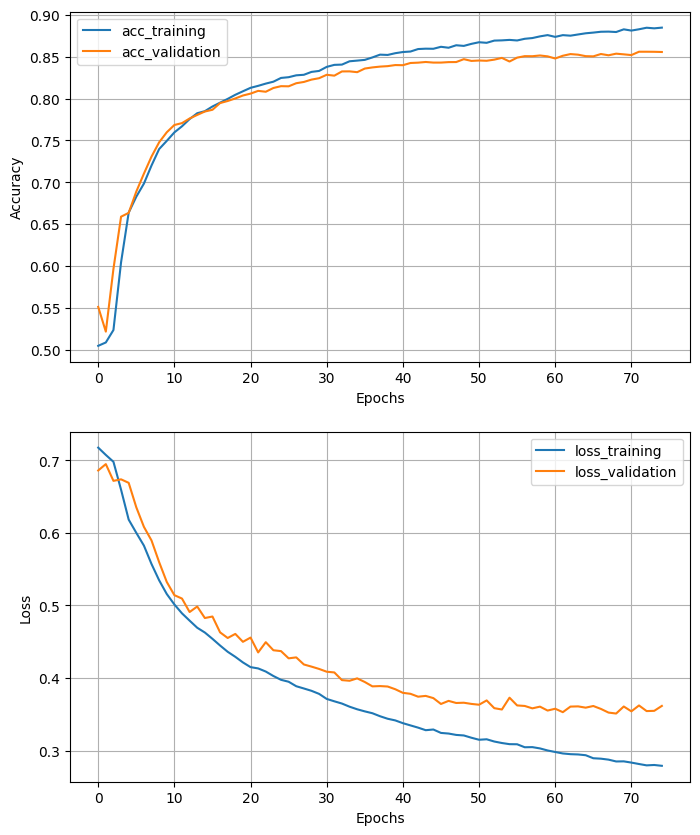

In [44]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [45]:
@torch.no_grad()
def test_trns(model, dataloader_test):
  model.eval()
  total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0
  for idx, (label, text) in enumerate(dataloader_test):
      pre_label = model(text, label)
      loss += criterion(pre_label, label)
      labels_form_pre_label = lambda x: 0. if x < 0.5 else 1.
      pre_label = torch.tensor(list(map(labels_form_pre_label, pre_label))).to(model.device)
      total_acc_test += (pre_label == label).sum().item()
      total_count_test += label.size(0)
      n_batches_test += 1
  accuracy_test = total_acc_test/total_count_test
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
  print(f"Test Accuracy: {100*accuracy_test:.4f}%")

In [46]:
test_trns(transformer, dataloader_test_trns)

Test Loss: 0.37297109 ---------- Test Accuracy: 85.2160%


`%ENDCODE%`